# Лабораторная работа №1

In [3]:
!pip install pandas
!pip install trimesh
!pip install scipy
!pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.9/688.9 kB 4.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import numpy as np
import math
import trimesh

# attach to logger so trimesh messages will be printed to console
#trimesh.util.attach_to_log()

# some formats represent multiple meshes with multiple instances
# the loader tries to return the datatype which makes the most sense
# which will for scene-like files will return a `trimesh.Scene` object.
# if you *always* want a straight `trimesh.Trimesh` you can ask the
# loader to "force" the result into a mesh through concatenation
mesh = trimesh.load('models/!EXPORT_Isaac_3DML.stl') #, force='mesh')

## POLYGON MESH

In [5]:
angle = math.pi / 2
direction = [-1, 0, 0]
center = [0, 0, 0]

rot_matrix = trimesh.transformations.rotation_matrix(angle, direction, center)

# transform method can be passed a (4, 4) matrix and will cleanly apply the transform
mesh.apply_transform(rot_matrix)

# preview mesh in an opengl window if you installed pyglet and scipy with pip
mesh.show()

## VOXEL

In [6]:
voxel_mesh = mesh.voxelized(0.1) 
voxel_mesh.show()

## POINT CLOUD

In [7]:
points_mesh = trimesh.convex.hull_points(mesh)

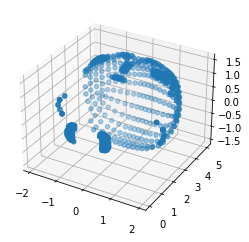

In [8]:
trimesh.points.plot_points(points_mesh, show=True)

## FUNCTION

In [9]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117.
# torch.cuda.is_available()

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /private/var/folders/b9/t74hdwd91l5c6gn1ppsv2c2w0000gn/T/pip-req-build-jldg6lvs
  Running command git clone --quiet https://github.com/facebookresearch/pytorch3d.git /private/var/folders/b9/t74hdwd91l5c6gn1ppsv2c2w0000gn/T/pip-req-build-jldg6lvs
  Running command git checkout -q 2f11ddc5ee7d6bd56f2fb6744a16776fab6536f7
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 2f11ddc5ee7d6bd56f2fb6744a16776fab6536f7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

In [9]:
# !pip install mesh-to-sdf
# !pip install scikit-learn
import mesh_to_sdf
center_mass = mesh.center_mass
query_points = np.array([[center_mass],[[3,3,3]]])
for point in query_points:
    print(
        "SDF{0} = {1}".format(point[0],mesh_to_sdf.mesh_to_sdf(mesh,point)[0])
)

SDF[2.98032415e-17 3.27906317e+00 6.27487771e-02] = -0.6143748760223389
SDF[3. 3. 3.] = 2.474323272705078


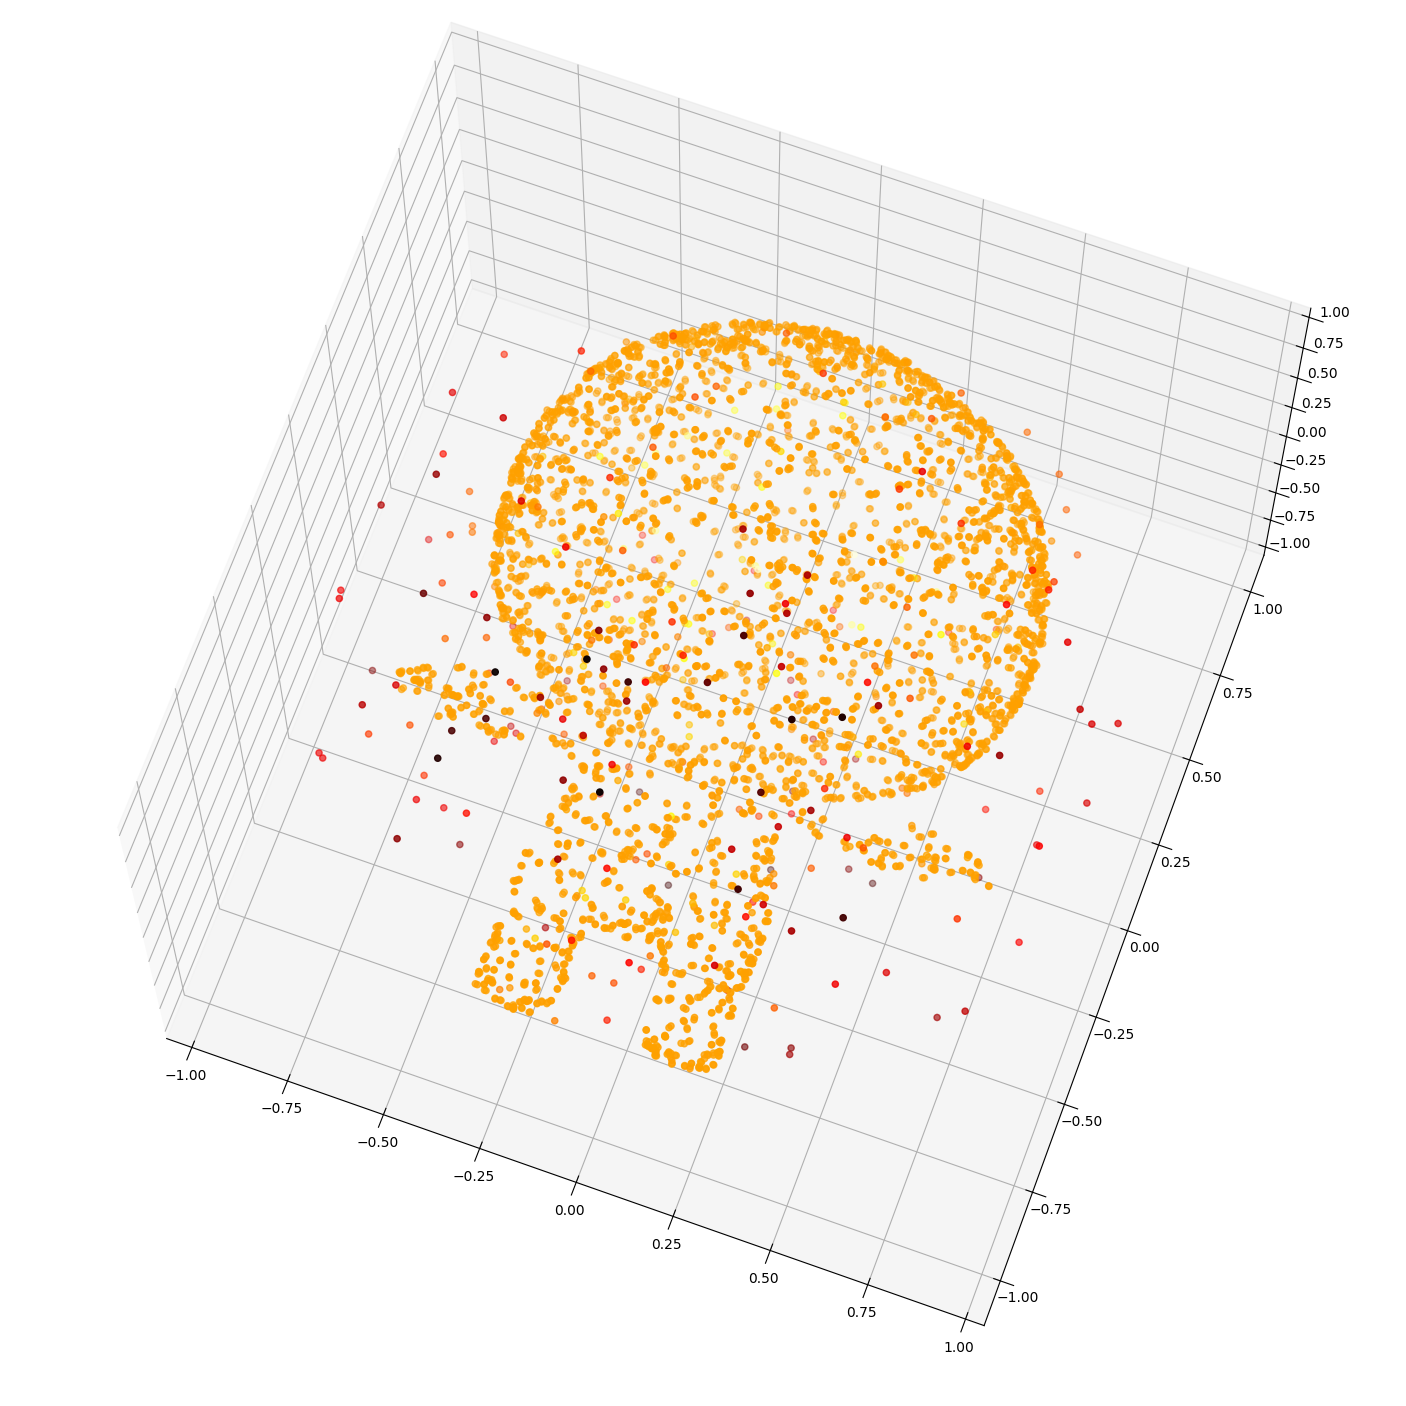

In [10]:
import matplotlib.pyplot as plt
points, sdf = mesh_to_sdf.sample_sdf_near_surface(mesh, number_of_points=5000)
fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=70, azim=-70)
ax.scatter(points[:, 0], points[:, 1], zs=-points[:, 2], c=sdf, cmap="hot_r")

## DEPTH (2,5D)

In [265]:
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform,
    RasterizationSettings, BlendParams,
    MeshRenderer, MeshRasterizer, SoftPhongShader, SoftSilhouetteShader
)

from pytorch3d.io import load_obj
from pytorch3d.structures.meshes import Meshes
from pytorch3d.renderer.mesh.textures import TexturesAtlas
from torchvision import transforms    

model_base_path = 'Models'
model_name = '!EXPORT_Isaac_3DML.obj'
model_path = os.path.join(model_base_path, model_name)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get vertices, faces, and auxiliary information
verts, faces, aux = load_obj(f=model_path,
                             device=device,
                             load_textures=True,
                             create_texture_atlas=True,
                             texture_atlas_size=4,
                             texture_wrap=None)

# Create a textures object
atlas = aux.texture_atlas

# Initialize the mesh with vertices, faces, and textures.
# Created Meshes object
obj_mesh = Meshes(verts=[verts],
                  faces=[faces.verts_idx],
                  textures=TexturesAtlas(atlas=[atlas]), )

# color = torch.zeros(1, verts.size(1), 3, device=device)
# obj_mesh.textures = TexturesVertex(verts_features=color)

print('We have {0} vertices and {1} faces.'.format(verts.shape[0], faces.verts_idx.shape[0]))

# Initialize the camera with camera distance, elevation, and azimuth angle
camera_distance = 9
camera_elv_angle = -50
camera_azi_angle = 30

R, T = look_at_view_transform(dist=camera_distance, elev=camera_elv_angle, azim=camera_azi_angle)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Here we set the output image to be of size 256 x 256
output_im_size = 512
raster_settings = RasterizationSettings(image_size=output_im_size, blur_radius=0.0, faces_per_pixel=1,)


We have 5206 vertices and 10400 faces.


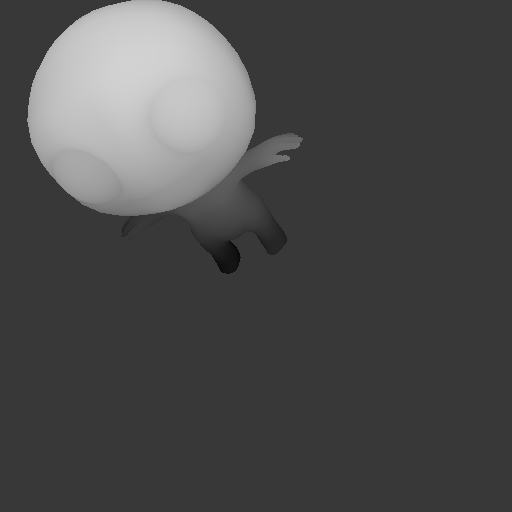

In [274]:
# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)

# The textured Phong shader interpolates the texture UV coordinates for
# each vertex, and samples from a texture image.
shader = SoftPhongShader(device=device, cameras=cameras)

# Create a mesh renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer, shader)

# output camera view image
# image = renderer(obj_mesh)
# camera_view = (image[..., :3].squeeze() * 255).byte().cpu().numpy()
# transforms.ToPILImage()(camera_view)

# output depth image
fragments = rasterizer(obj_mesh)
depth_map = (fragments.zbuf.squeeze() * -56).byte().cpu().numpy()
transforms.ToPILImage()(depth_map)